
# Factors Affecting Survivorship on the Titanic

The key predetermined question of interest for this dataset was which variables provided in the dataset were either associated or could predict who survived on the Titanic?  Let's dive in with some basic data exploration. 

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from pandas import DataFrame 
from pylab import *

In [2]:
df = pd.read_csv('titanic.csv')


## #0 Let's Do Some Basic Exploration

In [3]:
df.shape

(891, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Without referring to the dataset notes on kaggle, we see there are 12 variables and 891 datapoints or passengers we have information for.  We are missing about 20% of the values for age and about 80% of the values of Cabin.  While barely detectable, the 2 missing values from embarked could foul up analyses with that variable unless properly handeld. 

In [5]:
# What does the data look like?
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As a quick breakdown, every passenger has an Id, either survived (1) or did not (0), was given a class of cabin (1=high, 3=low), the passenger's name (Last, followed by title, then first & middle), sex, age, 'SibSp' (number of siblings present), Parch (number of parents or children present), ticket, fare, cabin, and embarked (indicates one of three locations the passenger embarked from).

Next, how many people from this dataset survived the titanic? 

In [6]:
df[['PassengerId', 'Survived']].groupby('Survived').count()

,PassengerId
Survived,
0,549
1,342


With '1' meaning survived, less than half of this dataset survived or 38% to be more specific.

From this point onward, I will explore how individual variables affect survival on the Titanic.  

Originally, I was drawn to exploring Sex, Age, and Pclass.  I was unclear how to explore SibSp (number of siblings) and Parch (number of parents or children) or Ticket, and I did not expect any helpful information could be extracted from Name. 

When searching for more information on the dataset on the kaggle site, I found Megan L. Risdal's comprehensive blog post exploring the same dataset combined with the test set using R.  Because she combined the test set with the training set, she had a larger dataset to work with.  The dataset I have explored so far is only the training set, so there will be descrpancies in numbers if any comparisons in analyses are made.  

After examining this post, I am inspired to attempt to replicate the analysis she did on Name.  That is, can I use regular expression operations to isolate a person's title from a passenger's name?  Megan created a new variable with this title excerpt and then used it to examine whether it was a strong predictor of passenger survival. 

After reading Megan's blog, I also realized analyzing Age would be a little more tricky than expected.  While I did not want to drop 177 rows with missing age values, I knew it would be a challenge to implement either rpart or recursive partitioning for regression or mice imputation.  She mentions both as viable options for predicting values for the missing rows. As a result, I am opting to learn a little about regular expression operations to analyze the name variable. 

On a final note, Megan performed a random forest regression on all of the variables to determine the order of the strength of the variables as predictors. I, on the other hand, will be performing independent statistical tests on each variable to determine if it can predict survival based on a grouping/factor difference. 

In order, I will explore if Sex, Name, and Pclass are predictors of a passenger's survival on the Titanic

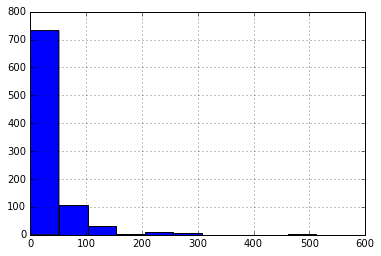

In [7]:
df.Fare.hist()

## #1 Sex and Survivorship

In [8]:
df.groupby(['Sex', 'Survived']).count()

PassengerId  Pclass  Name  Age  SibSp  Parch  Ticket  Fare  \
Sex    Survived                                                               
female 0                  81      81    81   64     81     81      81    81   
       1                 233     233   233  197    233    233     233   233   
male   0                 468     468   468  360    468    468     468   468   
       1                 109     109   109   93    109    109     109   109   

                 Cabin  Embarked  
Sex    Survived                   
female 0             6        81  
       1            91       231  
male   0            62       468  
       1            45       109

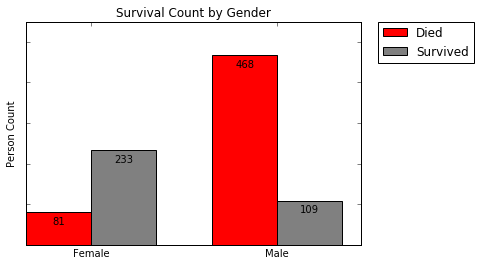

In [9]:
N = 2
Surv_0 = (81, 468)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, Surv_0, width, color='r')

Surv_1 = (233, 109)

rects2 = ax.bar(ind + width, Surv_1, width, color='grey')

# add some text for labels, title and axes ticks
ax.set_ylabel('Person Count')
ax.set_title('Survival Count by Gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Female', 'Male')) 
ax.yaxis.set_major_formatter(plt.NullFormatter())    # Gets rid of y-axis scale

ax.legend((rects1[0], rects2[0]), ('Died', 'Survived'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,550)


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-35, # box counts width & height
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

Males vs. Females: Barchart

In [10]:
sex_array = np.array([[81,468],[233,109]])

In [11]:
chi2_contingency(sex_array)

(260.71702016732104,
 1.1973570627755645e-58,
 1,
 array([[ 193.47474747,  355.52525253],
        [ 120.52525253,  221.47474747]]))

The χ2 value of 260.7 is much greater than the critical value of 3.841 (df=1) with a p-value < 0.001.  Thus, Sex is a significant factor in predicting death.  Based on the directionality from our bar-graph, it is better to be a female than a male on the Titanic if you want to survive.

##  #2 Name as a Predictor of Survivorship

The second variable of interst is to see if a person's title can predict a person's survival rate. 

### Creating a New Title Variable 

A New 'Title' Variable is created creating a copy of the 'Name' variable and stripping it of all characters but a perons'a title (ie. 'Mr', 'Capt', etc).

In [12]:
# Creates method to strip all but title from name including punctuation (periods/commans)
remove_name = re.compile("(.*, )|(\\..*)")

In [13]:
# Function to use method on each element of name series
def get_title(nameslist, editor):
    titles = []
    for i in nameslist:
        titles.append(editor.sub('',i))
    return titles

In [14]:
# New title variable is created using function and method above
df['Title'] = get_title(df['Name'], remove_name)

In [15]:
# List of all unique title names
pd.unique(df.Title.ravel())

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Some of these names above mean the same thing.  For instance, Mme is Madame or Mrs in French.  Mlle is Madamoiselle or Miss in French.   Lastly, Ms is a word of respect that does not indicate marriage status; however, because it typically means single, we will replace it with Miss.  The same goes for the above French words.  I will replace them with their English counterparts. 

### Grouping Uncommon Names & Grouping Synonymous Names (Ms./Mlle..etc) 

In [16]:
# Dict of synonymous names to replace
name_synonyms = {
            "Ms" : "Miss",
            "Mme" : "Mrs",
            "Mlle" : "Miss"
}

In [17]:
# Replaces any passengers with a title of a key above with its paired value (ie. 'Ms' is now 'Miss')
def remove_extras(extras):
    for i in extras:
        df['Title'] = df['Title'].replace(i, extras[i])

In [18]:
remove_extras(name_synonyms)

In [19]:
print pd.unique(df.Title.ravel())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Major' 'Lady' 'Sir' 'Col'
 'Capt' 'the Countess' 'Jonkheer']


In [20]:
df.groupby(['Sex', 'Title']).Title.count()

Sex     Title       
female  Dr                1
        Lady              1
        Miss            185
        Mrs             126
        the Countess      1
male    Capt              1
        Col               2
        Don               1
        Dr                6
        Jonkheer          1
        Major             2
        Master           40
        Mr              517
        Rev               6
        Sir               1
Name: Title, dtype: int64

In [21]:
DataFrame.hist(df["Fare"])

TypeError: unbound method hist_frame() must be called with DataFrame instance as first argument (got Series instance instead)

In [ ]:
uncommon_title = ('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Master')

In [ ]:
# All uncommon titles in the list above will now be replaced with a title of uncommon
# A warning may pop up about copying slices.  I am aware of this issue, and the code runs as expected. 
df.Title.loc[df['Title'].isin(uncommon_title)] = 'Uncommon'

In [ ]:
# Shows a breakdown of surival organized by titled and sex
df.groupby(['Sex','Title','Survived']).size()

What is particularly interesting from the above table is that this view clearly shows that all but three uncommon titles are held by males.  Only 3 females have uncommon titles. 

In [ ]:
N = 4
Surv_0 = (55,436,26,32)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, Surv_0, width, color='r')

Surv_1 = (130,81,100,31)

rects2 = ax.bar(ind + width, Surv_1, width, color='grey')

# add some text for labels, title and axes ticks
ax.set_ylabel('Person Count')
ax.set_title('Survival Count by Title')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Miss', 'Mr','Mrs','Uncommon')) 
ax.yaxis.set_major_formatter(plt.NullFormatter())    # Gets rid of y-axis scale

ax.legend((rects1[0], rects2[0]), ('Died', 'Survived'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,450)


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-25, # box counts width & height
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

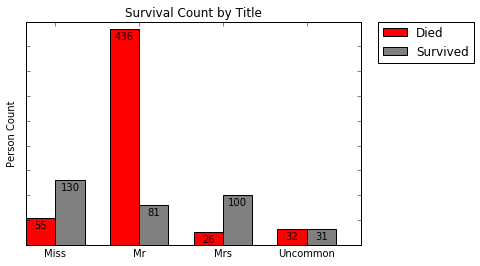

In [22]:
N = 4
Surv_0 = (55,436,26,32)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, Surv_0, width, color='r')

Surv_1 = (130,81,100,31)

rects2 = ax.bar(ind + width, Surv_1, width, color='grey')

# add some text for labels, title and axes ticks
ax.set_ylabel('Person Count')
ax.set_title('Survival Count by Title')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Miss', 'Mr','Mrs','Uncommon')) 
ax.yaxis.set_major_formatter(plt.NullFormatter())    # Gets rid of y-axis scale

ax.legend((rects1[0], rects2[0]), ('Died', 'Survived'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,450)


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-25, # box counts width & height
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

While the sample sizes differ greatly, it is apparent that being a woman on the Titanic was a huge advantage to increasing your odds of survival and even greater if you were a married woman (4 to 1) versus a single woman (~2 to 1). If you had an uncommon name, you had about 50% survival rate.  This is huge as almost all of these were men.  Ignoring the 3 women with the uncommon names, being a male with an uncommon name appeared to have a much higher survival rate (47%) compared to the survival rate of males with only 'Mr.' (16%).

The question is are these significant differences?  I will conduct a chi-square contingency test to find out.

### Analysis 

In [ ]:
title_array = np.array([[55,436,55,32],[130,81,100,31]])

In [ ]:
title_array

In [ ]:
chi2_contingency(title_array)

These results show a χ2 value of 242.68 which greatly exceeds the critical statitic value of 7.815 (df=3) and a p-value < 0.001. Consequently, a person's title via their name can be used to make a prediction about a passenger's outcome while on the Titanic.

Taking this a step further, I will conduct pair-wise chi-square tests to examine individual groups.

In [ ]:
chisquare(title_array)

As expected - and this could have been guessed by looking at the bar chart - all pair-wise tests except for the 'uncommon' group produced significant results.  The first three groups all produced χ2 values all greater  than 13 which all surpass a conservative critical value of 6.635 (alpha=0.01).  Additionally, these three groups had p-values < 0.001.  The fourth group, the 'uncommon' group, was non significant.  In other words, if a passenger went by 'Mr', he would likely die.  If a passenger went by 'Miss' or 'Mrs', she would likely live.  If a passenger had an uncommon name, we are unable to make an accurate prediction. 

In [ ]:
#The fourth test didn't test positive.   chi squared value of  χ2 = 0.015 and p=.90

## #3 Does Pclass have an Impact on Survival Rate?

The third and final variable we will investigate is Pclass on survival rate.  

In [ ]:
df[['PassengerId','Survived','Pclass']].groupby(['Pclass','Survived']).count()

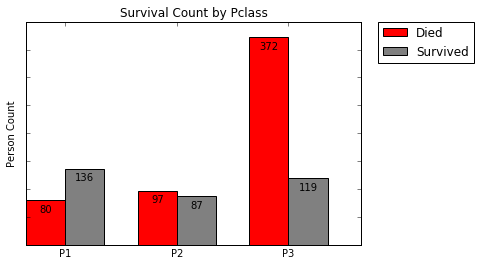

In [23]:
N = 3
Surv_0 = (80, 97, 372)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, Surv_0, width, color='r')

Surv_1 = (136, 87, 119)

rects2 = ax.bar(ind + width, Surv_1, width, color='grey')

# add some text for labels, title and axes ticks
ax.set_ylabel('Person Count')
ax.set_title('Survival Count by Pclass')
ax.set_xticks(ind + width)
ax.set_xticklabels(('P1', 'P2', 'P3')) 
ax.yaxis.set_major_formatter(plt.NullFormatter())    # Gets rid of y-axis scale

ax.legend((rects1[0], rects2[0]), ('Died', 'Survived'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,400)


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height-25, # box counts width & height
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

### Pclass Analysis

In [ ]:
pclass_table = np.array([[80, 97, 373],[136, 87, 119]])

In [ ]:
pclass_table.shape

In [ ]:
# Chi-squared contingency test
chi2_contingency(pclass_table)

The χ2 value of 103.31 much greater than the critical chi-squared value of 5.991(df=2) with a p-value < 0.001.  Pclass can be interpreted at a significant factor that affected survival rate.

To dig a littel deeper, I will conduct individual pair-wise chisquare tests.

In [ ]:
chisquare(pclass_table)

P1 and P3 produced significant results while P2 did not.  P1 and P3 had χ2 values of 14.5 and 131 respectively and p-values < 0.001.   Both of χ2 values exceed the conservative critical value of 6.635\*.  As a result, we can predict that a person likely lived if the passenger has a P1 status or died if that passenger had a P3 status. 

Based on this information alone, what percentage of the passengers can we accurately predict outcomes?

In [ ]:
# make a square figure and axes
figure(1, figsize=(6,6))
ax = axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = 'P1-Died', 'P1-Survived', 'P2-Died', 'P2-Survived', 'P3-Died', 'P3-Survived'
fracs = [9,15,11,10,42,13]
explode=(0.10,0, 0.10, 0, 0.10, 0)
colors = ['gold','gold','silver','silver','grey','grey']

pie(fracs, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

title('Class Proportions Split by Survival Outcome')

show()

Based on our previous findings above, we found that there is a more than a chance likelihood that a person in first class will survive and person in third class will die. Of the 24% of passengers in first class, we will properly predict 15% will survive.  Likewise, of the 55% of the ship's passenger's in third class, we will accurately predict 42% will die.  Including second class passengers who we can not make a prediction about their fate above chance, overall, we can account for 57% (42%+15%) of the passengers' fates. This is not great, but it's better than chance.  We may want to rely on other variables to make more accurate predictions.

## Conclusion

This wraps up this analysis.  To recap, a passenger's Sex, Name through use of their title, and Pclass can be used to predict a person's fate on the Titanic. While this does not generalize to all sub-groups within a factor, such as the P2 group in Pclass or the 'uncommon' titled passengers grouped from Name, we can still make greater than chance predictions about everyone else.  

### Challenges and Futher Explorations

Trying to find methods that mirrored what Megan used in R was a much greater challenge and required a great deal more time than I anticipated.  R has some very simple methods that in python require more code. While I am sure there are alternatives out there that are easier to implement and shorter than what I used, I will save seeking them out for another project.  

Another challenge was trying to identify the best statistical test to use.  I used chi squared contingency tables throughout due to the nature of the variables (nominal or ordinal (Pclass) and nominal (Survived)) and due to the fact that the dependent variable was always a count of those survived and those who died.  As a sidenote, I read about a number of chi square tests that branch off to perform more specific analyses.  One of these tests may have been more appropriate.  For anyone looking to replicate these tests or perform further analyses, this is one direction I suggest exploring. 

Exploring Megan L. Risdal's blog, my next steps would have been to explore the variables embarked and fare further.  However, due to time constraints, I will have to wait to implement these methods until another time.  Lastly, while all three factors were determined to be significant factors that predicted survival, a next goal of interest would be to incorporate them into a random forest regression to determine the order of their impact. 

### Resources Used:
https://www.kaggle.com/c/titanic/data for descriptions  
https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook for further ideas.   
http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas?rq=1
http://stackoverflow.com/questions/13842088/set-value-for-particular-cell-in-pandas-dataframe
